Exercise Sheet No. 9

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 21.06.2021, 8 am
>
> Tutor: Matthias Schniewind [matthias.schniewind@kit.edu](mailto:matthias.schniewind@kit.edu)  
> **Please ask questions in the forum and only contact the tutor for issues regarding the grading**

---

**Topic**: This exercise sheet will focus on recurrent neural networks, in particular a GRU implementation.

# Problem and Dataset

Recurrent neural networks are usually well suited for tasks where e.g. a time series of inputs need to be embedded into a fixed size latent representation and where the relationship in time within one sequence sample is important for predictions, e.g. to detect trends etc.

For this exercise I selected a time series regression problem based on open data and with some local and present relevance:  
As some of you might noticed Germany has a problem with air pollution in big cities like Berlin, Munich, Cologne or Stuttgart. To reduce the emissions of nitrogen dioxide general driving bans for diesel cars were discussed and introduced in some cities.  
On the other hand air pollution is not only dependent on traffic but also on the weather: Wind brings fresh air and dilutes the city air, rain washes substances out of the air, etc.  
Hence, a flexible driving ban which is only introduced for weekdays with weather conditions associated with a high pollution, e.g. no wind, longer dry periods, etc. could be introduced.  
To allow planning for commuters the ban should be announced at least one day ahead.

Hence, I collected weather data for the German meteorological office ([DWD](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html) 04928 Stuttgart Schnarrenberg) and NO2 data from the Federal Environmental Agency ([UBA](https://www.umweltbundesamt.de/daten/luft/luftdaten/stationen/eJzrXpScv9B4UXEykEhJXGVkYGSoa2Cma2i8qCRzkaHJorzUBYuKSxYsSUl0K4LLGpgB-SH5yKqTEycsyq1iW5Sb3LQ4J7HktIPnqnmvGuWOL87JSz_toHLOxeGTxWwADVorxg==) DEBW099 - Stuttgart Arnulf-Klett-Platz) for Stuttgart.

All data is in 10 min. resolution. The weather data consists of:
- Mean Temperature in 2m height `TT_10` ($°C$)
- Relative Humidity `RF_10` ($\%$)
- Mean Wind speed `RF_10` ($\frac{m}{s}$)
- Mean Wind direction `DD_10` ($°$)
- Sum of Sunshine Duration `SD_10` ($h$)
- Precipitation height `RWS_10` ($mm$)

The UBA data only has one column, the NO2 level in $\frac{\mu g}{m^3}$.

We can now use the 6 weather features 7 one-hot encoded weekdays and the past measurements for NO2 to predict the maximum hourly mean NO2 level for the next 24 hour window.

As the last exercises were quite intense, the Corona cases are low and the weather is nice, I think it is time for you to finally catch up with some social activities.   
Hence, this exercise will only focus on the implementation of a gated recurrent unit as a Tensorflow layer and everything else is given.

Nevertheless, I encourage you to explore the dataset and think about ways to improve the model. This task is not from any standard example dataset and there is quite some room for improvements.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_hdf('weather_no2_stuttgart.h5')
df.head()

DWD_04928                                  UBA_DEBW099
                        TT_10  RF_10 FF_10  DD_10 SD_10 RWS_10         NO2
2016-01-01 00:00:00       3.3  100.0   0.9  130.0   0.0    0.0        49.0
2016-01-01 00:10:00       3.2  100.0   0.9  130.0   0.0    0.0        49.0
2016-01-01 00:20:00       3.1   98.9   0.6  130.0   0.0    0.0        49.0
2016-01-01 00:30:00       3.1   99.8   1.1  290.0   0.0    0.0        49.0
2016-01-01 00:40:00       3.2   99.6   1.3  200.0   0.0    0.0        49.0

As recurrent NNs take long to train, we won't do a CV in this notebook, but only a simple train test split with a 20% test size.  

Additionally, we need to have different shapes for the input to the GRU and to our benchmark model...

In [3]:
# Weather data for 24 hours as input
feature_len = 6*24

# Predict 24 h ahead
delay = 0

# Extract samples staring every 6 hours
step = 6*6

# total number of extracted windows
n_samples = int(np.floor((df.shape[0]-feature_len-delay-step)/step))

# scalers
X_scaler = StandardScaler()
y_scaler = StandardScaler()

features = df
features = pd.DataFrame(data=X_scaler.fit_transform(features), columns=features.columns)
labels = df.UBA_DEBW099

# One-hot encoded weekdays
weekdays = LabelBinarizer().fit_transform(df.index.weekday)

# One X for time series input where the second dimension is the length of the time series'
X = np.zeros([n_samples, feature_len, features.shape[1]])

# One X for the one-hot encoded weekdays, one for each sample (no time series here)
X2 = np.zeros([n_samples, 7])

# And one regression output
y = np.zeros([n_samples, 1])

for i in range(n_samples):
    # Get the 24 hour feature data
    X[i, :, :features.shape[1]] = features.iloc[i*step:i*step+feature_len, :]
    
    # Assign the weekday encoding
    X2[i, :] = weekdays[i*step]

    # max. hourly mean of the next 24 hrs:
    h_max = 0
    for n in range(int(step/6)):
        current_max = labels.iloc[i*step+feature_len+delay+n*6:i*step+feature_len+delay+(n+1)*6, 0].mean()
        h_max = max(h_max, current_max)
    y[i, 0] = h_max

y = y_scaler.fit_transform(y)

# Data for the benchmark
X_ = np.concatenate([X.reshape(X.shape[0], X.shape[1]*X.shape[2]), X2], axis=1)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y, test_size=.2, random_state=42)

# Data for the GRU
X_train, X_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X2, y, test_size=.2, random_state=42)

# Benchmark

When approaching a new problem with complex ML models, it is always important to test a trivial benchmark as a reference to evaluate whether the model complexity actually adds value. Here we can simply use a linear regression.



In [4]:
def linear_regression():
    return LinearRegression()


def train(model, X_train, y_train, weights=None, validation_data=None, epochs=150, batch_size=512):
    if model.__module__.split('.')[0] == 'tensorflow':
        history = model.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            class_weight=weights,
                            validation_data=validation_data
                           )
        return history
    elif model.__module__.split('.')[0] == 'sklearn':
        model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
        return
    else:
        raise Exception('Can only handle sklearn or keras models!')

In [5]:
model = linear_regression()
model.fit(X_train_, y_train_)
y_pred_ = model.predict(X_test_)
print(f'R2:  {r2_score(y_test_, y_pred_)}')
print(f'MSE: {mean_squared_error(y_test_, y_pred_)}')

R2:  0.6197590667981233
MSE: 0.38826429069719126


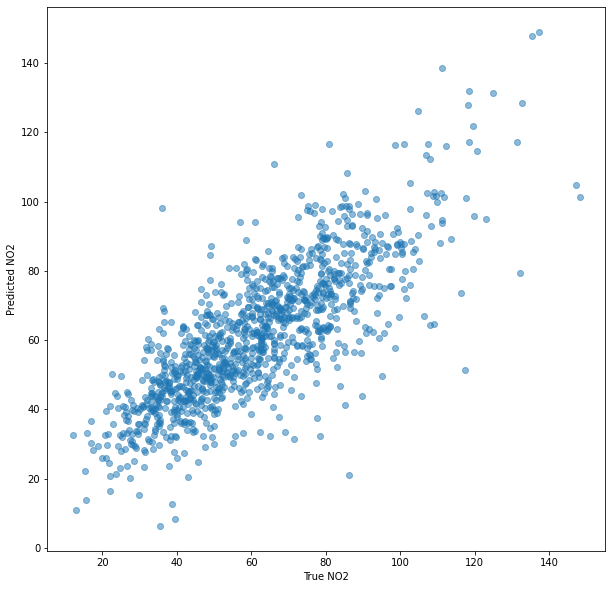

In [6]:
fig, ax = plt.subplots(figsize=[10,10])
ax.scatter(y_scaler.inverse_transform(y_test_), y_scaler.inverse_transform(y_pred_), alpha=0.5)
ax.set_xlabel('True NO2')
ax.set_ylabel('Predicted NO2')
plt.show()

So we get a trend but are far from a usable model. E.g. for a true NO2 value of 100 we get predictions ranging from 50 -120...

Now to your actual task:

# Gated Recurrent Units (GRU)
![gru](https://classic.d2l.ai/_images/gru_3.svg)

The Gated Recurrent Unit can be viewed as a simplified yet the equally powerful version of the Long Short-Term Memory (LSTM) cell. Both of them have control on when a hidden state $H_t$ should be updated and also when it should be reset. 

In the GRU architecture, a sigmoid activation function is used in layers of gate $R_t$ and $Z_t$, therefore the output of these two gates are both vectors with entries in the interval $(0, 1)$. The gate is considered "open" when its output is close to $1$ and "close" if it outputs $0$.  
By switching between "open" and "close", the reset gate $R_t$ has control on how much information from the previous states is stored in the candidate state $\tilde{H_t}$. On the other hand $Z_t$ determines how much the new candidate state $\tilde{H_t}$ is used.


Let us describe how the activation of the $j$-th hidden unit is computed.

## Reset gate $R_t$

$r_{tj} = \sigma([W_{r}x_t]_j + [U_{r}h_{t-1}]_j)$  


## Update gate $Z_t$

$z_{tj} = \sigma([W_{z}x_t]_j + [U_{z}h_{t-1}]_j)$


## Candidate state $\tilde{h_j}$

$\tilde{h_j} = tanh([W_{h}x_t]_j + [U_{h}(r_{tj}\otimes h_{t-1})]_j)$


## Output $h_{t}$

$h_{t} = z_{tj}\otimes h_{t-1} + (1 - z_{tj})\otimes \tilde{h_{j}}$



1. $W_{r}$, $W_{z}$, $W_{h}$ are the weight matrices of each of the three layers for their connection to the input vector $x_t$ at the current timestep $t$.
2. $U_{r}$, $U_{z}$, $U_{h}$ are the weight matrices of each of the three layers for their connection to the hidden state $h_{t-1}$ from the previous timestep $t$.
3. $\sigma$ stands for sigmoid activation function, and $tanh$ is the tangent function.

In [7]:
class SimpleGRUcell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SimpleGRUcell, self).__init__(**kwargs)
        # output dimension
        self.units = units
        # state dimension
        self.state_size = units
    
    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        # Initializer for the input weights matrix, used for the linear transformation of the inputs
        w_init = initializers.GlorotUniform()
        # Initializer for the state weights matrix, used for the linear transformation of the states
        u_init = initializers.Orthogonal()
        
        # weights of gate r
        # input weights
        self.w_r = None
        # YOUR CODE HERE
        self.w_r = tf.Variable(
            initial_value=w_init(shape=(input_dim, self.state_size)), 
            name="W_r"
        )
        # state weights
        self.u_r = None
        # YOUR CODE HERE
        self.u_r = tf.Variable(
            initial_value=u_init(shape=(self.state_size, self.state_size)), 
            name="U_r"
        )
        
        # weights of gate z
        # input weights
        self.w_z = None
        # YOUR CODE HERE
        self.w_z = tf.Variable(
            initial_value=w_init(shape=(input_dim, self.state_size)), 
            name="W_z"
        )
        # state weights
        self.u_z = None
        # YOUR CODE HERE
        self.u_z = tf.Variable(
            initial_value=u_init(shape=(self.state_size, self.state_size)), 
            name="U_z"
        )
        
        # weight of h_candidate
        # input weights:
        self.w_h = None
        # YOUR CODE HERE
        self.w_h = tf.Variable(
            initial_value=w_init(shape=(input_dim, self.state_size)), 
            name="W_h"
        )
        # state weights
        self.u_h = None
        # YOUR CODE HERE
        self.u_h = tf.Variable(
            initial_value=u_init(shape=(self.state_size, self.state_size)), 
            name="U_h"
        )
        
        self.build = True
        
    def call(self, x_t, states):
        h_tm1 = states[0]
        
        r_t = None
        z_t = None
        h_candidate = None
        h_t = None
        
        # YOUR CODE HERE
        sigmoid = keras.activations.sigmoid
        tanh = keras.activations.tanh
        
        r_t = sigmoid(x_t @ self.w_r + h_tm1 @ self.u_r)
        z_t = sigmoid(x_t @ self.w_z + h_tm1 @ self.u_z)
        
        h_candidate = tanh(x_t @ self.w_h + h_tm1 * r_t @ self.u_h)
        h_t = z_t * h_tm1 + (1 - z_t) * h_candidate
        
        return h_t, [h_t]

Next we implement a simple RNN. We need to differentiate between the time series input and the weekday input to the network and hence use the functional API:

In [8]:
# R2 metric using tensors
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def rnn(X, y):
    cell = SimpleGRUcell(15)
    
    # First input for time series
    in_0 = keras.layers.Input(shape=X.shape[1:])
    # Second input for weekdays
    in_1 = keras.layers.Input(shape=(7,))
    # RNN layer
    x_0 = keras.layers.RNN(cell)(in_0)
    # A little bit of regularization
    x_1_d = keras.layers.Dropout(.2)(x_0)
    # Concattenating the GRU embedding of the input sequence and the weekday encoding
    x_1 = keras.layers.Concatenate()([in_1, x_1_d])
    x_2 = keras.layers.Dense(units=1, activation='linear')(x_1)
    
    # Here we pass the input layers as a list
    model = keras.Model(inputs=[in_0, in_1], outputs=x_2)
    
    optimizer = keras.optimizers.Adam()
    loss = keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[r2]
                 )
    return model


gru_model = rnn(X_train, y_train)
gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 7)]     0                                            
__________________________________________________________________________________________________
rnn (RNN)                       (None, 15)           990         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 15)           0           rnn[0][0]                        
______________________________________________________________________________________________

In [9]:
history = train(gru_model,
                [X_train, X2_train],
                y_train,
                validation_data=([X_test, X2_test], y_test))

Epoch 1/150
10/10 [==============================] - 2s 117ms/step - loss: 1.0347 - r2: -0.0348 - val_loss: 0.9408 - val_r2: 0.0869
Epoch 2/150
10/10 [==============================] - 1s 92ms/step - loss: 0.9331 - r2: 0.0635 - val_loss: 0.8556 - val_r2: 0.1716
Epoch 3/150
10/10 [==============================] - 1s 94ms/step - loss: 0.8567 - r2: 0.1401 - val_loss: 0.7895 - val_r2: 0.2372
Epoch 4/150
10/10 [==============================] - 1s 91ms/step - loss: 0.7985 - r2: 0.2028 - val_loss: 0.7384 - val_r2: 0.2878
Epoch 5/150
10/10 [==============================] - 1s 92ms/step - loss: 0.7455 - r2: 0.2317 - val_loss: 0.7000 - val_r2: 0.3252
Epoch 6/150
10/10 [==============================] - 1s 91ms/step - loss: 0.7225 - r2: 0.2817 - val_loss: 0.6695 - val_r2: 0.3553
Epoch 7/150
10/10 [==============================] - 1s 91ms/step - loss: 0.6842 - r2: 0.3168 - val_loss: 0.6461 - val_r2: 0.3773
Epoch 8/150
10/10 [==============================] - 1s 91ms/step - loss: 0.6661 - r2: 0

10/10 [==============================] - 1s 104ms/step - loss: 0.3541 - r2: 0.6551 - val_loss: 0.3729 - val_r2: 0.6340
Epoch 126/150
10/10 [==============================] - 1s 107ms/step - loss: 0.3623 - r2: 0.6193 - val_loss: 0.3744 - val_r2: 0.6309
Epoch 127/150
10/10 [==============================] - 1s 107ms/step - loss: 0.3548 - r2: 0.6373 - val_loss: 0.3691 - val_r2: 0.6386
Epoch 128/150
10/10 [==============================] - 1s 105ms/step - loss: 0.3522 - r2: 0.6482 - val_loss: 0.3756 - val_r2: 0.6301
Epoch 129/150
10/10 [==============================] - 1s 104ms/step - loss: 0.3526 - r2: 0.6451 - val_loss: 0.3648 - val_r2: 0.6430
Epoch 130/150
10/10 [==============================] - 1s 101ms/step - loss: 0.3502 - r2: 0.6448 - val_loss: 0.3798 - val_r2: 0.6251
Epoch 131/150
10/10 [==============================] - 1s 103ms/step - loss: 0.3529 - r2: 0.6505 - val_loss: 0.3652 - val_r2: 0.6425
Epoch 132/150
10/10 [==============================] - 1s 105ms/step - loss: 0.3524

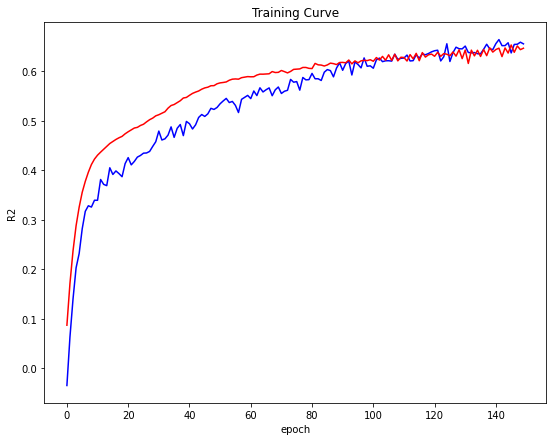

In [10]:
fig, ax = plt.subplots(figsize=[9,7])
ax.plot(history.history['r2'], 'b')
ax.plot(history.history['val_r2'], 'r')
ax.set_title('Training Curve')
ax.set_xlabel('epoch')
ax.set_ylabel('R2')
plt.show()

In [11]:
y_pred = gru_model.predict([X_test, X2_test])
print(f'R2:  {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2:  0.6467503955600731
MSE: 0.36070342546238704


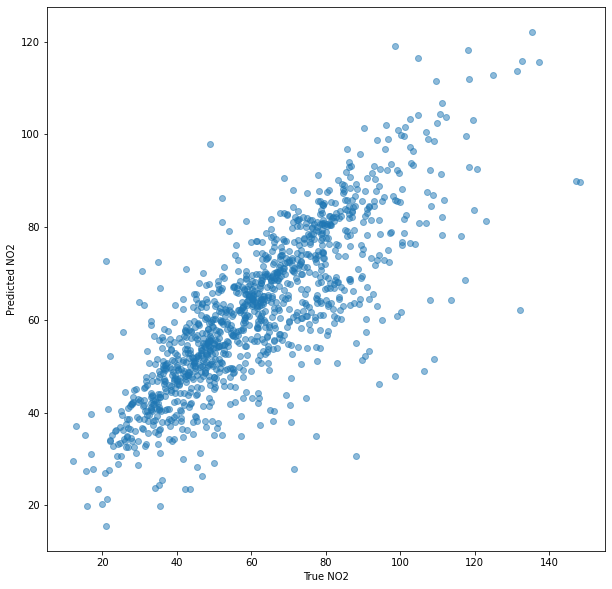

In [12]:
fig, ax = plt.subplots(figsize=[10,10])
ax.scatter(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred), alpha=0.5)
ax.set_xlabel('True NO2')
ax.set_ylabel('Predicted NO2')
plt.show()

In [16]:
# This determines whether you passed
r2_gru = r2_score(y_test, y_pred)
assert r2_gru > 0.6

You should be able to reach an R2 of around 0.65 here.  
How do you rate this result? Also take into consideration the number of trainable parameters in the two models.

Now go and enjoy the sun!

...and while you are doing that, think about how to improve the model, by architecture, feature engineering, etc. I hope for a little discussion when we go through the exercise together after the deadline.